In [22]:
'''IMPORT LIBRARIES'''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import load_model
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings("ignore")

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

%matplotlib inline

np.random.seed(42)

In [2]:
'''Build test DataGenerator'''

def get_test_datagen(df, directory='data/test_images/', batch_size_test=1):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
            directory=directory,
            dataframe=df,
            x_col='filename',
            y_col='y',
            target_size=(299, 299),
            color_mode="rgb",
            batch_size=batch_size_test,
            class_mode="categorical",
            shuffle=False,
            seed=42)
    return test_generator

In [3]:
# Code source: scikit-learn.org
def plot_confusion_matrix(ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    cm_original=cm.copy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(img, ax=ax, cax=cax)
    tick_marks = np.arange(len(classes))
    ax.set(xticks=tick_marks, yticks=tick_marks)
    ax.set_xticklabels(classes, rotation=0, fontsize=13)
    ax.set_yticklabels(classes, fontsize=13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    thresh = 1 / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j]*100, '.0f') +  '%  (' +format(cm_original[i, j], 'd') + ')',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=15)

    ax.set_title(title, fontsize=15)
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)
    ax.grid('off')

In [4]:
''' Code for displaying images whose class the predictor was highly certain/uncertain of '''

def show_case_within_p_range(df, pred_class, y_hats, p_hats, thresh_low, thresh_high, ax, directory):
    p_k = np.array([p_hats[i] if (y_hats[i] == pred_class) else 0 for i, p in enumerate(p_hats)])
    
    idx = np.where((p_k <= thresh_high) & (p_k >= thresh_low))[0][0]
    p_val = p_hats[idx]
    file = df.loc[idx, 'filename']
    img = plt.imread(directory + file)
    ax.imshow(img, cmap='gray')
    ax.set_title('$\hat{p}$(y=' + f'{pred_class}) = {p_val:.3}', fontsize=16)
    ax.axis('off')

def show_max_certainty_case(df, pred_class, y_hats, p_hats, ax, directory):
    p_k_max = np.max(p_hats[y_hats == pred_class])
    show_case_within_p_range(df, pred_class, y_hats, p_hats, p_k_max, p_k_max, ax, directory)

def show_min_certainty_case(df, pred_class, y_hats, p_hats, ax, directory):
    p_k_min = np.min(p_hats[y_hats == pred_class])
    show_case_within_p_range(df, pred_class, y_hats, p_hats, p_k_min, p_k_min, ax, directory)

### Model 0

In [5]:
test_df_model_0 = pd.read_csv("data/test_df_model_0.csv")
test_df_model_0['y'] = test_df_model_0['y'].astype(str)

model_0 = load_model("models/resnet50_model_0_best_weights.h5")

In [6]:
test_generator = get_test_datagen(test_df_model_0)

y_pred_0 = model_0.predict_generator(test_generator, test_generator.n)
p_hat_0 = np.amax(y_pred_0, axis=1)
y_hat_0 = np.argmax(y_pred_0, axis=1)

Found 15364 images belonging to 5 classes.


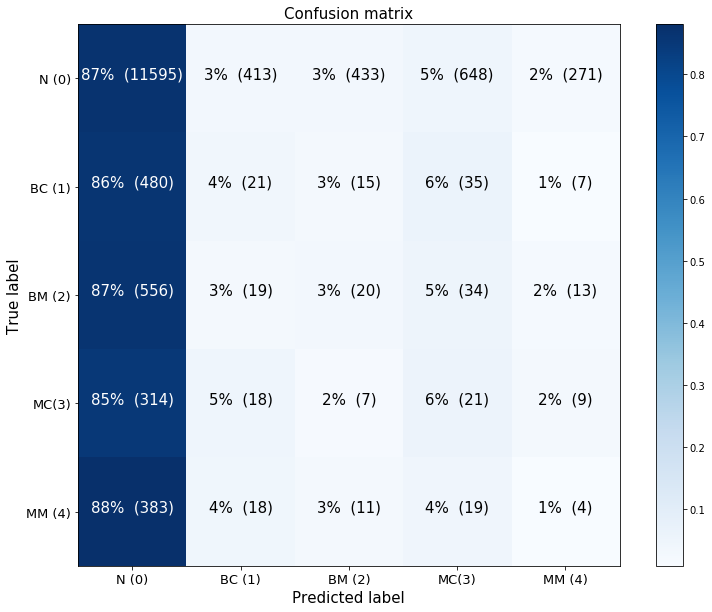

In [7]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
cnf_matrix = confusion_matrix(test_df_model_0['y'].astype(int), y_hat_0)
plot_confusion_matrix(ax, cnf_matrix, classes=['N (0)','BC (1)','BM (2)','MC(3)','MM (4)'], normalize=True)
fig.tight_layout()

In [8]:
test_df_model_0['y'].value_counts(normalize=True)

0    0.869565
2    0.041786
1    0.036319
4    0.028313
3    0.024017
Name: y, dtype: float64

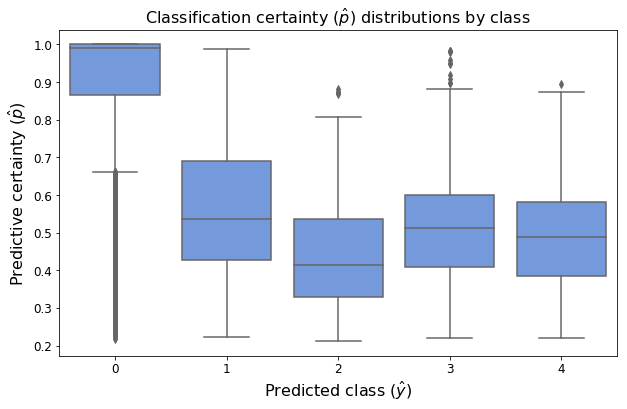

In [9]:
# plot certainty distribution (p values) for each predicted group
fig, ax = plt.subplots(figsize=(10,6))

sns.boxplot(x='y', y='p', data=pd.DataFrame({"p":p_hat_0, "y":y_hat_0}), ax=ax, color='cornflowerblue')

ax.set_xlabel("Predicted class ($\hat{y}$)", fontsize=16)
ax.set_ylabel('Predictive certainty ($\hat{p}$)', fontsize=16)
ax.tick_params(labelsize=12)
ax.set_title("Classification certainty ($\hat{p}$) distributions by class", fontsize=16);

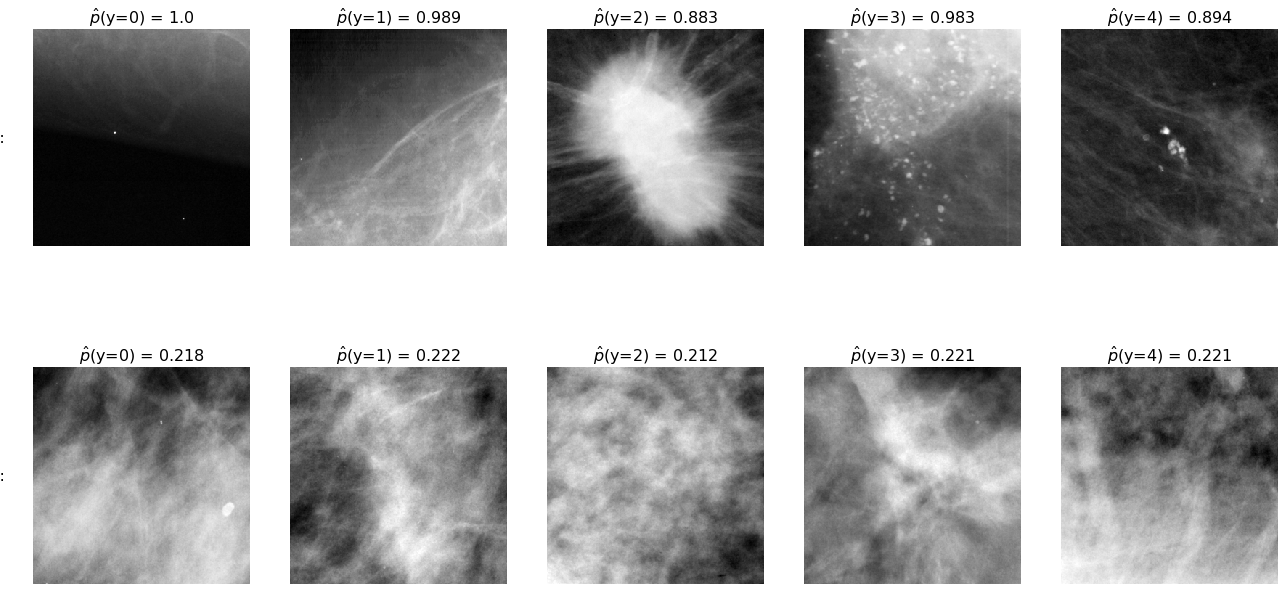

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18,10))
for c in range(5):
    show_max_certainty_case(test_df_model_0, c, y_hat_0, p_hat_0, axes[0,c], 'data/test_images/')
    show_min_certainty_case(test_df_model_0, c, y_hat_0, p_hat_0, axes[1,c], 'data/test_images/')
    
for ax, row in zip(axes[:,0], ['high certainty:', 'low certainty:']):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad+2, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=16, ha='right', va='center')

fig.tight_layout()

### Model 2

In [13]:
test_df_model_2 = pd.read_csv("data/test_df_model_2.csv")
test_df_model_2['y'] = test_df_model_2['y'].astype(str)

model_2 = load_model("models/resnet50_model_2_best_weights.h5")

In [14]:
test_generator = get_test_datagen(test_df_model_2)

y_pred_2 = model_2.predict_generator(test_generator, test_generator.n)
p_hat_2 = np.amax(y_pred_2, axis=1)
y_hat_2 = np.argmax(y_pred_2, axis=1)+1

Found 2004 images belonging to 4 classes.


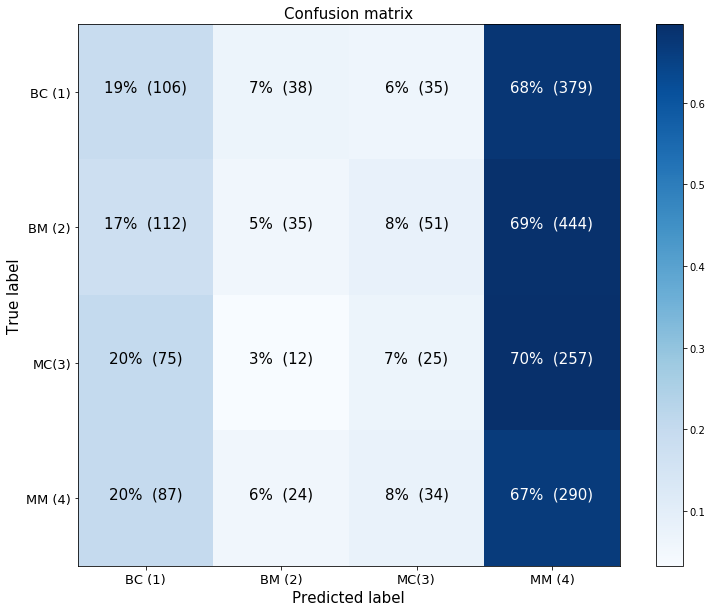

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
cnf_matrix = confusion_matrix(test_df_model_2['y'].astype(int), y_hat_2)
plot_confusion_matrix(ax, cnf_matrix[:-1,1:], classes=['BC (1)','BM (2)','MC(3)','MM (4)'], normalize=True)
fig.tight_layout()

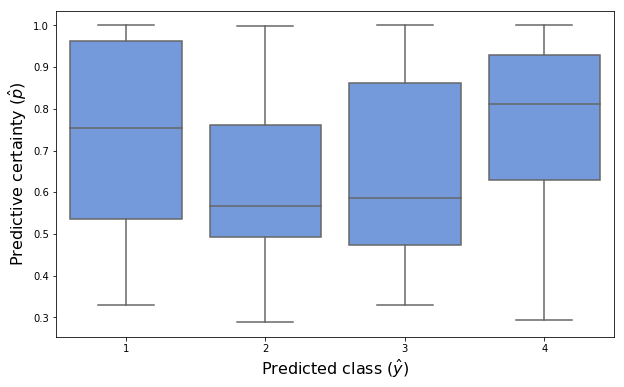

In [16]:
# boxplot of certainty distribution (p values) for each predicted group
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x='y', y='p', data=pd.DataFrame({"p":p_hat_2, "y":y_hat_2}), ax=ax, color='cornflowerblue')
ax.set_xlabel("Predicted class ($\hat{y}$)", fontsize=16)
ax.set_ylabel('Predictive certainty ($\hat{p}$)', fontsize=16);

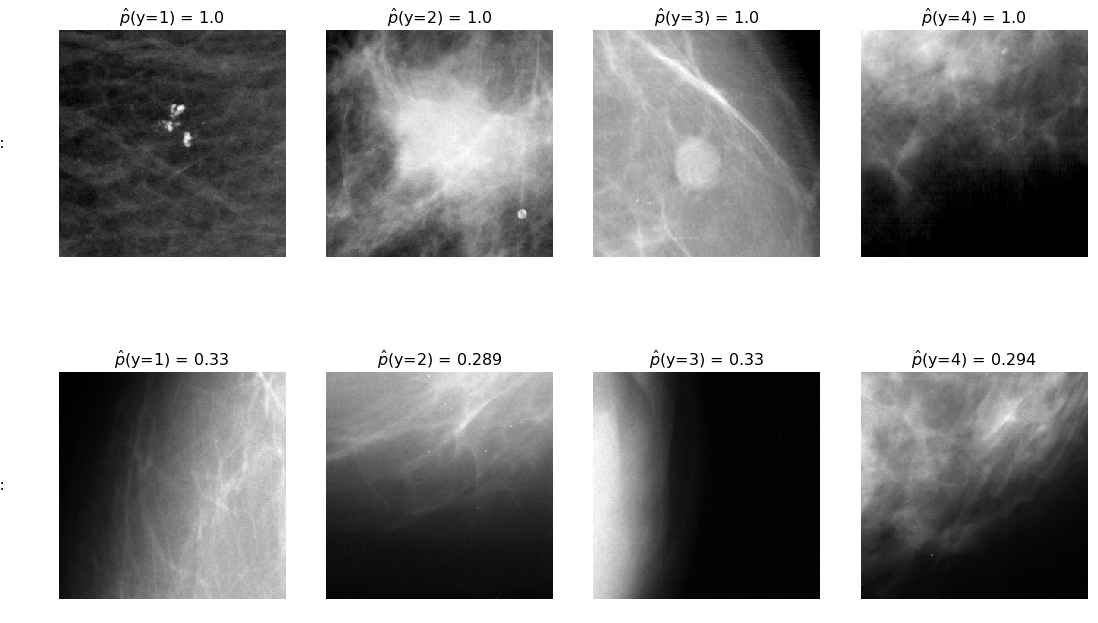

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i, c in enumerate([1,2,3,4]):
    show_max_certainty_case(test_df_model_2, c, y_hat_2, p_hat_2, axes[0,i], 'data/test_images/')
    show_min_certainty_case(test_df_model_2, c, y_hat_2, p_hat_2, axes[1,i], 'data/test_images/')


for ax, row in zip(axes[:,0], ['high certainty:', 'low certainty:']):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad+2, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=16, ha='right', va='center')

fig.tight_layout()

### Test model 0 on full images, masked and unmasked

In [18]:
full_img_df = pd.DataFrame({'subtlety': [5,5,5,5,3,3,3,3], 
                            'y': ['1','2','3','4'] * 2, 
                            'filename': ["calc_full299x299_00344.png", "mass_full299x299_00173.png", 
                                         "calc_full299x299_00390.png", "mass_full299x299_00016.png",
                                         "calc_full299x299_00325.png", "mass_full299x299_00177.png",
                                         "calc_full299x299_00497.png", "mass_full299x299_00324.png"]})

masked_img_df = pd.DataFrame({'y': ['1','2','3','4'] * 2, 
                              'filename': ["calc_299x299_50buf_mask_00344.png", "mass_299x299_50buf_mask_00173.png", 
                                           "calc_299x299_50buf_mask_00390.png", "mass_299x299_50buf_mask_00016.png",
                                           "calc_299x299_50buf_mask_00325.png", "mass_299x299_50buf_mask_00177.png",
                                           "calc_299x299_50buf_mask_00497.png", "mass_299x299_50buf_mask_00324.png"]})

full_img_datagen = get_test_datagen(full_img_df, directory='data/CBIS-DDSM_examples/output_images/')
masked_img_datagen = get_test_datagen(masked_img_df, directory='data/CBIS-DDSM_examples/masked_images/')

Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [19]:
y_pred_full_img = model_0.predict_generator(full_img_datagen, full_img_datagen.n)
p_hat_full_img = np.amax(y_pred_full_img, axis=1)
y_hat_full_img = np.argmax(y_pred_full_img, axis=1)

In [20]:
y_pred_masked_img = model_0.predict_generator(masked_img_datagen, masked_img_datagen.n)
p_hat_masked_img = np.amax(y_pred_masked_img, axis=1)
y_hat_masked_img = np.argmax(y_pred_masked_img, axis=1)

In [21]:
pd.DataFrame({"True $y$ (complete image)": ['1','2','3','4'] * 2,
              "$\hat{y}$: complete image": y_hat_full_img,
              "$\hat{p}$: complete image": p_hat_full_img,
              "$\hat{y}$: masked image": y_hat_masked_img,
              "$\hat{p}$: masked image": p_hat_masked_img})

,True $y$ (complete image),$\hat{y}$: complete image,$\hat{p}$: complete image,$\hat{y}$: masked image,$\hat{p}$: masked image
0,1,4,0.688789,4,0.708869
1,2,4,0.712141,4,0.568441
2,3,4,0.641636,4,0.650779
3,4,1,0.265910,0,0.741181
4,1,4,0.515154,4,0.480932
5,2,4,0.484582,4,0.479284
6,3,4,0.459287,0,0.469885
7,4,0,0.393802,0,0.493522


The classifier performed poorly on identifying the particular type and malignancy of the abnormalities in the complete images, though the results on first appearance suggest that the classifier at least identified the presence of an abnormality in the complete images (with the one exception of the final image in which the model egregiously misclassifies an image with a malignant mass as lacking any sort of suspicious abnormality). 

However, even after occluding the region of interest, the classifier continued to identify most of the images as containing a mass, revealing that it would be incorrect to conclude that the classifier had accurately identified the presence of an abnormality in the images. It is possible that there were additional features (e.g. smaller growths) in the image that were not occluded, but which revealed the images to contain an abnormality. To test this, we would have wished to create saliency maps for these images, both with and without the occluded regions of interest. Unfortunately, time did not permit us to do so.